#**ResNet Training (CIFAR - 10)**

###**1. Import Library & Define Resnet model**

In [1]:
import torch
import torch.nn as nn

from functools import partial
from dataclasses import dataclass
from collections import OrderedDict
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os
import torchvision
import torchvision.transforms as transforms


class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        

conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels =  in_channels, out_channels
        self.blocks = nn.Identity()
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels
    


class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(OrderedDict(
        {
            'conv' : nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            'bn' : nn.BatchNorm2d(self.expanded_channels)
            
        })) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(OrderedDict({'conv': conv(in_channels, out_channels, *args, **kwargs), 
                          'bn': nn.BatchNorm2d(out_channels) }))

class ResNetBasicBlock(ResNetResidualBlock):
    expansion = 1
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation(),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )
        
class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation(),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation(),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )
        
class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x
    
class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by increasing different layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
                 activation=nn.ReLU, block=ResNetBasicBlock, *args,**kwargs):
        super().__init__()
        
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,  *args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x
    

class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x
    
class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
def resnet18(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[2, 2, 2, 2])

def resnet34(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[3, 4, 6, 3])

def resnet50(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 6, 3])

def resnet101(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 23, 3])

def resnet152(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 8, 36, 3])

###**2. Download CIFAR-10**

In [2]:
#Download CIFAR10 DATASET

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


###**3. CUDA setting & Define Train,Test function**

In [3]:
#gpu setting & define Training function

device = 'cuda'

net = resnet101(3,10)           #resnet101 선언
net = net.to(device)
net = torch.nn.DataParallel(net)
cudnn.benchmark = True

learning_rate = 0.1
file_name = 'resnet101_cifar10.pt'

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

def train(epoch):
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        benign_outputs = net(inputs)
        loss = criterion(benign_outputs, targets)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = benign_outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if batch_idx % 100 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current benign train accuracy:', str(predicted.eq(targets).sum().item() / targets.size(0)))
            print('Current benign train loss:', loss.item())

    print('\nTotal benign train accuarcy:', 100. * correct / total)
    print('Total benign train loss:', train_loss)
    total_accuracy = 100. * correct / total;

    return total_accuracy , train_loss


def test(epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

    print('\nTest accuarcy:', 100. * correct / total)
    print('Test average loss:', loss / total)
    total_accuracy = 100. * correct / total;
    test_loss = loss / total

    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')

    return total_accuracy , test_loss

def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

###**4. Run Training & Save log**

In [4]:
# for epoch in range(0, 200):
log_train_total_accuracy =[]
log_train_total_loss = []
log_test_total_accuracy =[]
log_test_total_loss =[]


for epoch in range(0, 20):
    adjust_learning_rate(optimizer, epoch)
    train_total_accuracy, train_total_loss = train(epoch)
    test_total_accuracy, test_total_loss = test(epoch)
    log_train_total_accuracy.append(train_total_accuracy)
    log_train_total_loss.append(train_total_loss)
    log_test_total_accuracy.append(test_total_accuracy)
    log_test_total_loss.append(test_total_loss)


[ Train epoch: 0 ]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Current batch: 0
Current benign train accuracy: 0.09375
Current benign train loss: 2.794175863265991

Current batch: 100
Current benign train accuracy: 0.1171875
Current benign train loss: 4.150548458099365

Current batch: 200
Current benign train accuracy: 0.1640625
Current benign train loss: 2.363341808319092

Current batch: 300
Current benign train accuracy: 0.171875
Current benign train loss: 2.197540760040283

Total benign train accuarcy: 15.282
Total benign train loss: 3437.3970201015472

[ Test epoch: 0 ]

Test accuarcy: 19.63
Test average loss: 0.022500086975097658
Model Saved!

[ Train epoch: 1 ]

Current batch: 0
Current benign train accuracy: 0.140625
Current benign train loss: 2.270207166671753

Current batch: 100
Current benign train accuracy: 0.234375
Current benign train loss: 2.081759214401245

Current batch: 200
Current benign train accuracy: 0.203125
Current benign train loss: 2.0721733570098877

Current batch: 300
Current benign train accuracy: 0.203125
Current beni

In [11]:
file_name = "/content/checkpoint/resnet101_cifar10.pt"
device = 'cuda'

net = resnet101(3,10)
net = net.to(device)
net = torch.nn.DataParallel(net)
cudnn.benchmark = True

checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

<All keys matched successfully>

In [12]:
file_name = 'resnet101_cifar10.pt'

for epoch in range(0, 20):
    adjust_learning_rate(optimizer, epoch)
    train_total_accuracy, train_total_loss = train(epoch)
    test_total_accuracy, test_total_loss = test(epoch)
    log_train_total_accuracy.append(train_total_accuracy)
    log_train_total_loss.append(train_total_loss)
    log_test_total_accuracy.append(test_total_accuracy)
    log_test_total_loss.append(test_total_loss)


[ Train epoch: 0 ]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Current batch: 0
Current benign train accuracy: 0.6015625
Current benign train loss: 1.1015297174453735

Current batch: 100
Current benign train accuracy: 0.546875
Current benign train loss: 1.2198727130889893

Current batch: 200
Current benign train accuracy: 0.5234375
Current benign train loss: 1.300838828086853

Current batch: 300
Current benign train accuracy: 0.6875
Current benign train loss: 1.017952799797058

Total benign train accuarcy: 56.402
Total benign train loss: 471.5751749277115

[ Test epoch: 0 ]

Test accuarcy: 58.72
Test average loss: 0.011460229206085205
Model Saved!

[ Train epoch: 1 ]

Current batch: 0
Current benign train accuracy: 0.59375
Current benign train loss: 1.2127803564071655

Current batch: 100
Current benign train accuracy: 0.4921875
Current benign train loss: 1.220662236213684

Current batch: 200
Current benign train accuracy: 0.6171875
Current benign train loss: 1.085648775100708

Current batch: 300
Current benign train accuracy: 0.578125
Current ben

In [13]:
file_name = "/content/checkpoint/resnet101_cifar10.pt"
device = 'cuda'

net = resnet101(3,10)
net = net.to(device)
net = torch.nn.DataParallel(net)
cudnn.benchmark = True

checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

file_name = 'resnet101_cifar10.pt'

for epoch in range(0, 20):
    adjust_learning_rate(optimizer, epoch)
    train_total_accuracy, train_total_loss = train(epoch)
    test_total_accuracy, test_total_loss = test(epoch)
    log_train_total_accuracy.append(train_total_accuracy)
    log_train_total_loss.append(train_total_loss)
    log_test_total_accuracy.append(test_total_accuracy)
    log_test_total_loss.append(test_total_loss)


[ Train epoch: 0 ]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Current batch: 0
Current benign train accuracy: 0.578125
Current benign train loss: 1.3188430070877075

Current batch: 100
Current benign train accuracy: 0.4765625
Current benign train loss: 1.4675040245056152

Current batch: 200
Current benign train accuracy: 0.5234375
Current benign train loss: 1.280327558517456

Current batch: 300
Current benign train accuracy: 0.5859375
Current benign train loss: 1.1778665781021118

Total benign train accuarcy: 56.786
Total benign train loss: 471.18967270851135

[ Test epoch: 0 ]

Test accuarcy: 58.75
Test average loss: 0.01148865357041359
Model Saved!

[ Train epoch: 1 ]

Current batch: 0
Current benign train accuracy: 0.640625
Current benign train loss: 1.0929784774780273

Current batch: 100
Current benign train accuracy: 0.5078125
Current benign train loss: 1.313258409500122

Current batch: 200
Current benign train accuracy: 0.5703125
Current benign train loss: 1.1394160985946655

Current batch: 300
Current benign train accuracy: 0.59375
Curren

###**5. Plotting Train Accuracy & Loss**

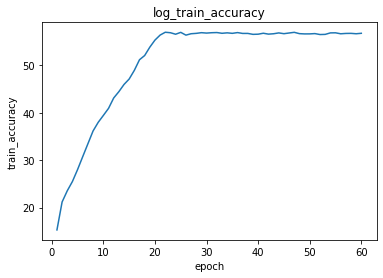

In [14]:
epoch =[]

for i , loss in enumerate(log_test_total_loss):
  epoch.append(i+1)

import matplotlib.pyplot as plt

plt.title('log_train_accuracy')
plt.plot(epoch , log_train_total_accuracy)
plt.xlabel('epoch')
plt.ylabel('train_accuracy')
plt.show()  

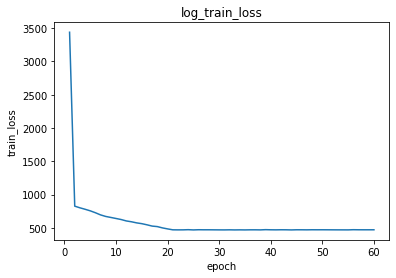

In [15]:
import matplotlib.pyplot as plt

plt.title('log_train_loss')
plt.plot(epoch , log_train_total_loss)
plt.xlabel('epoch')
plt.ylabel('train_loss')
plt.show()

###**6. Plotting Test Accuracy & Loss**

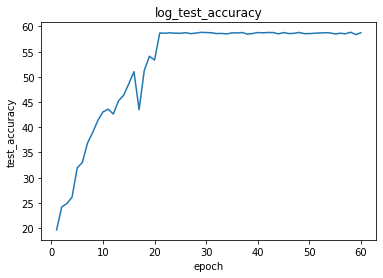

In [16]:
import matplotlib.pyplot as plt

plt.title('log_test_accuracy')
plt.plot(epoch , log_test_total_accuracy)
plt.xlabel('epoch')
plt.ylabel('test_accuracy')
plt.show()

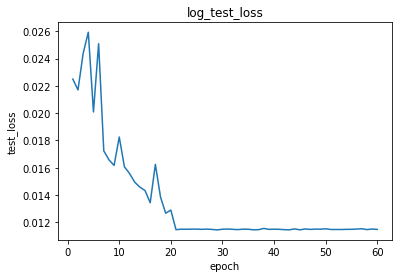

In [17]:
import matplotlib.pyplot as plt

plt.title('log_test_loss')
plt.plot(epoch , log_test_total_loss)
plt.xlabel('epoch')
plt.ylabel('test_loss')
plt.show()

###**7. Print Result**

In [18]:
print(log_train_total_accuracy)
print(log_train_total_loss) 
print(log_test_total_accuracy)
print(log_test_total_loss)

[15.282, 21.178, 23.54, 25.5, 28.026, 30.754, 33.462, 36.16, 37.99, 39.448, 40.934, 43.124, 44.454, 45.978, 47.126, 48.954, 51.194, 52.082, 53.846, 55.344, 56.402, 56.998, 56.894, 56.58, 56.972, 56.39, 56.684, 56.762, 56.906, 56.822, 56.898, 56.932, 56.778, 56.872, 56.768, 56.924, 56.748, 56.75, 56.552, 56.588, 56.786, 56.602, 56.682, 56.856, 56.694, 56.838, 56.98, 56.702, 56.646, 56.652, 56.712, 56.514, 56.546, 56.86, 56.878, 56.674, 56.746, 56.762, 56.68, 56.776]
[3437.3970201015472, 826.7947065830231, 801.951898097992, 780.1289913654327, 756.7028796672821, 728.1160551309586, 695.6807528734207, 672.4348508119583, 657.2015486955643, 641.6910747289658, 625.8433381319046, 604.7545081377029, 592.2092543840408, 575.7200243473053, 563.8625159263611, 546.9038125276566, 527.6393016576767, 520.0523073673248, 500.45236921310425, 485.36072051525116, 471.5751749277115, 470.67815643548965, 471.08217430114746, 473.55702698230743, 470.04847663640976, 472.7931135892868, 471.9820985198021, 472.013771

###**8. Model Summary**

In [19]:
from torchsummary import summary

model = resnet101(3, 10)
summary(model.cuda(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 256, 8, 8]          16,384
       BatchNorm2d-6            [-1, 256, 8, 8]             512
        Conv2dAuto-7             [-1, 64, 8, 8]           4,096
       BatchNorm2d-8             [-1, 64, 8, 8]             128
              ReLU-9             [-1, 64, 8, 8]               0
       Conv2dAuto-10             [-1, 64, 8, 8]          36,864
      BatchNorm2d-11             [-1, 64, 8, 8]             128
             ReLU-12             [-1, 64, 8, 8]               0
       Conv2dAuto-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25